In [12]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import time

While in development, MLA is not available via pip, so to import it, you need to add the location of the repository on your local machine to the python path.

In [2]:
import os
import sys
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ~/mla
import mla

Processing ./mla
  Created wheel for mla-thejevans: filename=mla_thejevans-0.0.1-py3-none-any.whl size=28911 sha256=4e0a7f62159c3e5e1169273b9a0f09424044ea2d8ebf9a86f7e8b099894ffb14
  Stored in directory: /tmp/pip-ephem-wheel-cache-tsb_z5pz/wheels/8c/48/b3/9140259f9b0da6559e99825e8695b86a19be0cff6f5377a4a1
Successfully built mla-thejevans


The `EventModel` class in this implementation uses data, simulation, and grl numpy arrays in the same format that Michael used in the workshops he ran. We need to load in some arrays to do an analysis.

In [3]:
import glob
def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

def read_mc(file, n_keep = 50000):
    sim = np.load(file)
    # Reduce the number of events in the simulation
    # to a manageable level.
    N = len(sim)
    sim = np.random.choice(sim, n_keep)    # cut down to n_keep events
    sim['ow'] /= float(n_keep)/float(N)    # correct the weights
    print("Reduced the number of simulation events from ",
         "{} to {}".format(N, len(sim)))
    # Show the possible keys available here:
    print("Keys available in simulation:")
    print(sorted(sim.dtype.names))
    print()
    return sim

DATA_PATH = "/home/jovyan/data2"

# Read in all of the data files
data_files = DATA_PATH + "/IC86_*exp.npy"
data = read(glob.glob(data_files))
print("Keys available in data:")
print(sorted(data.dtype.names))
print()

# Read in the MC files 
sim_files = DATA_PATH + "/IC86_2012_MC.npy"
sim = read_mc(sim_files, n_keep=100000)

# Read in the GRL file
grl = np.load(DATA_PATH + "/IC86_2012_GRL.npy")

Keys available in data:
['angErr', 'azi', 'dec', 'event', 'logE', 'ra', 'run', 'subevent', 'time', 'zen']

Reduced the number of simulation events from  11595414 to 100000
Keys available in simulation:
['angErr', 'azi', 'dec', 'event', 'logE', 'ow', 'ra', 'run', 'subevent', 'time', 'trueDec', 'trueE', 'trueRa', 'zen']



To start an analysis, you need a `Source`, an `EventModel`, and a `TestStatistic`. Let's start with the `Source`. Currently, our software supports point-source objects only. 

In [4]:
source = mla.sources.Source(
    name="TXS",
    ra=np.deg2rad(77.3583),
    dec=np.deg2rad(5.6931)
)

Next, we need an `EventModel`. This is an object that holds everything that will be implemented by Michael's public data package. Once that is ready, We will make an `EventModel` object that interfaces with it, leaving the rest of our package the same.

The only `EventModel` that is currently ready-to-go is the `I3EventModel` class. Building this object is probably the most complicated part of starting an analysis. Here is a list of parameters that it takes:

Required:
- `source`: A `Source` object
- `data`: A numpy array of real events to be used for background event generation
- `sim`: A numpy array of monte-carlo events to be used for signal event generation
- `grl`: A numpy array of good runs to be used to select times of generated events
- `gamma`: A number representing the assumed spectral index for calculating simulation event weights
- `background_time_profile`: An object that is a subclass of `GenericProfile` representing the temporal PDF of the background events
- `signal_time_profile`: A similar object for the signal events

Optional:
- `sampling_width`: The width in radians of a declination band used to filter out events far from the source to reduce computation time (default: 3 deg)
- `background_sin_dec_bins`: Either a number of equally spaced bins to use, or an array of bin edges for creating a background spatial pdf in sin(declination) (default: 500)
- `background_window`: A length of time (in MJD) to use to sample background events from prior to the time window of interest. Useful for analyses with short time windows that likely have more signal than usual. (default: 14)
- `withinwindow`: A flag for choosing whether to use the events in the time window of interest as background, or to use the value in `background_window` to select a differnt background window. (default: False)
- `signal_sin_dec_bins`: Either a number of equally spaced bins to use, or an array of bin edges for creating a grid of energy splines (default: 50)
- `log_energy_bins`: Either a number of equally spaced bins to use, or an array of bin edges for creating a grid of energy splines (default: 50)
- `gamma_bins`: Either a number of equally spaced bins to use, or an array of bin edges for creating a spline interpolation at each bin in the grid (default: 50)
- `verbose`: A flag for printing status information while building the event model. (default: False)

Before we can build an `I3EventModel`, we need time profiles for signal and background. We have these built-in options for time profiles:
- `UniformProfile`: Takes a `start` in MJD and a `length` in MJD and represents a uniform distribution between those times.
- `GaussProfile`: Takes a `mean` in MJD and a `sigma` in MJD and represents a normal distribution with those parameters.
- `CustomProfile`: Takes a 1D-histogram in time as the shape of the pdf and an `offset` as a time shift of the histogram and represents a step-function distribution with the given parameters.

In [5]:
start = 56224
length = 158
background_time_profile = mla.time_profiles.UniformProfile(start, length)
signal_time_profile = mla.time_profiles.UniformProfile(start, length)

model = mla.models.I3EventModel(
    source=source,
    data=data,
    sim=sim,
    grl=grl,
    gamma=-2,
    background_time_profile=background_time_profile,
    signal_time_profile=signal_time_profile,
    sampling_width=np.radians(5),
    withinwindow=True,
)

/opt/conda/lib/python3.8/site-packages/mla/models.py:155: RuntimeWarning: invalid value encountered in greater
  good = np.isfinite(ratio[i]) & (ratio[i] > 0)


Finally, we need a `TestStatistic`. Currently, only a standard signal-over-background LLH test statistic is defined, `LLHTestStatistic`. This class is very flexible, though. During initialization, you give a list of likelihood terms as parameters. You can give as many or as few as you like, and in whatever order you like. Currently there are four available terms:

- `SpatialTerm`: Takes no parameters. Uses the spatial pdfs defined in the `EventModel` to calculate a spatial signal-over-background ratio (sob)
- `TimeTerm`: Takes as parameters both a signal and background time profile so that you can attempt to fit using different profiles than you gave to the `EventModel` for injecting events. Currently, this term allows for the signal time profile parameters to be fitting parameters, but not the background parameters.
- `I3EnergyTerm`: Only works with `I3EventModel` models. Takes a default spectral index (`gamma`) as a parameter. This value can be a fitting parameter.
- `threeml.test_statistics.ThreeMLEnergyTerm`: Only works with `threeml.models.ThreeMLEventModel` models. Takes no parameters.

In [6]:
bg_fit_time_pro = copy.deepcopy(background_time_profile)
sig_fit_time_pro = copy.deepcopy(signal_time_profile)
        
ts = mla.test_statistics.LLHTestStatistic([
    mla.test_statistics.SpatialTerm(),
    mla.test_statistics.TimeTerm(
        bg_fit_time_pro,
        sig_fit_time_pro,
    ),
    mla.test_statistics.I3EnergyTerm(gamma=-2),
])

The `LLHTestStatistic` class also has $n_s$ as an optional fitting parameter. If you do not choose to fit it, the class will use a newton methods approach to find the best $n_s$ in every fitting step, which is generally faster.

From here, we can put together what we have built into an `Analysis` object. The analysis should be static object to be shared between threads in multithreaded applications or sent as a pickle file to cluster jobs. Initialization is straightforward:

In [7]:
analysis = mla.analysis.Analysis(
    model=model,
    test_statistic=ts,
    source=source,
)

Now that you have an `Analysis`, you can start on your analysis!

There are four basic functions available in the `analysis` module for this:
- `produce_trial`: Takes an `Analysis` and optional parameters for injecting signal, either a `flux_norm` (time-integrated flux normalization) or `n_signal_observed` to set the number of signal events injected. Returns a numpy array of combined signal and background events.
- `evaluate_ts`: Takes an `Analysis`, `events`, and `params` (manually-set fitting parameters). Returns a float test statistic value for the given events and parameters.
- `minimize_ts`: Takes an `Analysis`, `events`, and optionally `test_params` and `bounds`. Uses an optional `minimizer` (`scipy.optimize.minimize` by default) to minimize the `test_params` within the `bounds`. Returns a dictionary of the bests test statistic value and the best-fit parameters (always returns best-fit $n_s$, even if it is not a fitting parameter).
- `produce_and_minimize`: Takes an `Analysis`, a number of trials to run (`n_trials`), and optional parameters for `produce_trial` and `minimize_ts`. Returns a list of `minimize_ts` results, one for each trial.

Parameters should be a structured numpy array, with `dtype` names matching the expected variable names in the test statistic terms. Examples:
- for any test statistic: `ns`
- for `I3EnergyTerm`: `gamma`
- for `TimeTerm`: `mean`, `sigma`, `start`, `length`, `offset`

Let's produce a trial and then minimize the test statistic:

49648
[(    120777, 37162196, 2, 0.25330531, 0.47434135, 4.58645356, 2.04474551, 56261.93216098, 3.18235389, 0.00560971, 0.45675262)
 (    120866, 74659310, 0, 4.6454422 , 0.55796283, 3.29387435, 2.12780304, 56275.08430921, 2.97095924, 0.01005268, 0.5294591 )
 (    122211, 79428620, 0, 3.05595652, 0.24965006, 1.60209049, 1.82078236, 56266.60661619, 3.20245258, 0.01326552, 0.24706489)
 ...
 (1102906735,    26618, 0, 1.36128858, 0.09474498, 1.12395724, 1.6462274 , 56265.19201804, 3.98282088, 0.00492628, 0.0946033 )
 (1102904674,   103803, 0, 1.34943495, 0.09548157, 6.07116475, 1.63789548, 56363.98858885, 3.95107386, 0.00239901, 0.09533656)
 (1107002762,      304, 0, 1.35002428, 0.10169479, 0.92735274, 1.60644703, 56359.27650644, 5.72895899, 0.00193917, 0.10151959)]


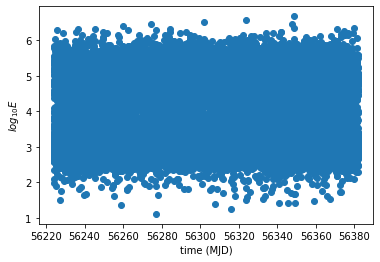

[(730.47534469, 95.343304)]


In [8]:
trial = mla.analysis.produce_trial(
    analysis,
    n_signal_observed=100,
)
print(len(trial))
print(trial)
# Plot the trial events
plt.scatter(trial['time'], trial['logE'])
plt.xlabel('time (MJD)')
plt.ylabel(r'$log_{10}E$')
plt.show()

# Generate parameter array for minimizing
## Here: minimize both spectral index (gamma) and n_s
#test_params = mla.generate_params(
#            gamma=-2,
#            ns=90,
#        )
#bounds = [(-4, -1), (0, 150)]

## Here: just miminize n_s
test_params = mla.generate_params(
            ns=90
)
bounds = [(0, 150)]

result = mla.analysis.minimize_ts(
    analysis=analysis,
    events=trial,
    bounds=bounds,
    test_params=test_params,
    as_array=True,

)

print(result)

Now, lets use `produce_and_minimize` to do the same with 10 trials:

In [9]:
results = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=10,
    n_signal_observed=100,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

for result in results:
    print(result)

(640.14406414, 93.11306539)
(734.27043887, 105.25083136)
(661.17472469, 97.56911288)
(679.80215189, 97.18237199)
(671.06044946, 102.13665746)
(622.78848457, 101.78951322)
(689.3207295, 103.0551458)
(625.48510804, 92.43072324)
(695.1749967, 97.78861629)
(655.61103782, 101.98078521)


In [25]:
# Produce and minimize n trials, then plot the ts distribution

# Enter an integer value for the number of trials you want for...
# (1) Trials involving injected signal
n_inj_trials = 15000

# (2) Background only trials
n_bkg_trials = 75000

# Get a timestamp before running to use later
t_initial = time.time()

print("Producing " + str(n_inj_trials) + " trials n_inj = 50")
best_fit_arr_50 = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=n_inj_trials,
    n_signal_observed=50,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

print("Producing " + str(n_inj_trials) + " trials n_inj = 10")
best_fit_arr_10 = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=n_inj_trials,
    n_signal_observed=10,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

print("Producing " + str(n_inj_trials) + " trials n_inj = 5")
best_fit_arr_5 = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=n_inj_trials,
    n_signal_observed=5,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

print("Producing " + str(n_bkg_trials) + " bg only trials")
best_fit_arr_bg = mla.produce_and_minimize(
    analysis=analysis,
    n_trials=n_bkg_trials,
    n_signal_observed=0,
    bounds=bounds,
    test_params=test_params,
    as_array=True,
)

# Get another timestamp and see how long the simulation took
t_final = time.time()
t_total = t_final - t_initial
time_format = time.strftime("%H:%M:%S", time.gmtime(t_total))
tri_tot = (3 * n_inj_trials) + n_bkg_trials
print("This simulation took " + time_format + " to complete " + str(tri_tot) + " trials.")
print(t_total)

Producing 15000 trials n_inj = 50
Producing 15000 trials n_inj = 10
Producing 15000 trials n_inj = 5
Producing 75000 bg only trials
This simulation took 08:22:55 to complete 120000 trials.


In [27]:
ts_bg, ns_bg = zip(*best_fit_arr_bg)
ts_50, ns_50 = zip(*best_fit_arr_50)
ts_10, ns_10 = zip(*best_fit_arr_10)
ts_5, ns_5 = zip(*best_fit_arr_5)


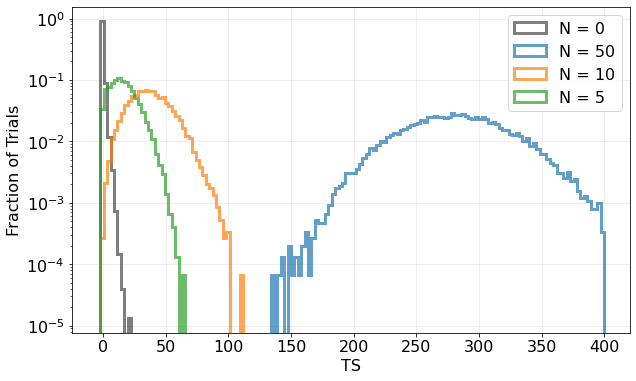

In [28]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(-5, 400, 150)

ax.hist(ts_bg,
        bins = bins,
        weights = np.ones_like(ts_bg)/len(ts_bg),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0',
       )

ax.hist(ts_50,
        bins = bins,
        weights = np.ones_like(ts_50)/len(ts_50),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = 50')

ax.hist(ts_10,
        bins = bins,
        weights = np.ones_like(ts_10)/len(ts_10),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = 10')

ax.hist(ts_5,
        bins = bins,
        weights = np.ones_like(ts_5)/len(ts_5),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = 5')

ax.legend(loc='upper right', fontsize=16,)
plt.yscale('log')
ax.grid(alpha=0.25)
#ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

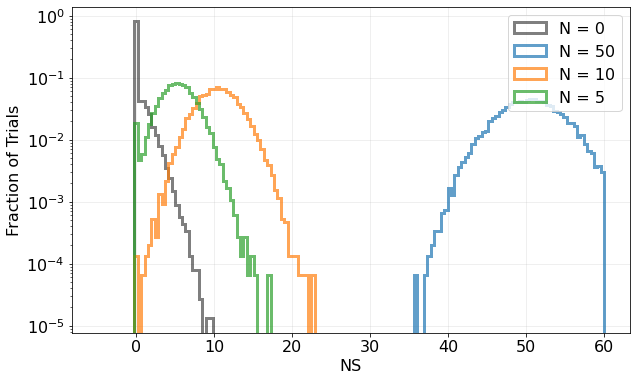

In [29]:
# Plot the best fit ns
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(-5, 60, 150)

ax.hist(ns_bg,
        bins = bins,
        weights = np.ones_like(ns_bg)/len(ns_bg),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0',
       )

ax.hist(ns_50,
        bins = bins,
        weights = np.ones_like(ns_50)/len(ns_50),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = 50')

ax.hist(ns_10,
        bins = bins,
        weights = np.ones_like(ns_10)/len(ns_10),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = 10')

ax.hist(ns_5,
        bins = bins,
        weights = np.ones_like(ns_5)/len(ns_5),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = 5')

ax.legend(loc='upper right', fontsize=16,)
plt.yscale('log')
ax.grid(alpha=0.25)
#ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("NS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

Things to do:
* bring in 7 yrs of data (Erik will provide conversion from csv to npy tool)
* currently, this uses a 158 time window, want to use ALL data in a uniform time profile.
* n_injected here is as "n events" -> option to use signal normalization

Starting to setup an analysis
* background only TS distributions.
* signal injections (flux vs. n_injected above)
* find point where you make "discovery" and are "sensitive"
* then look at real data.  What is your TS, where does it land relative to these distributions?  Did you discovery anything?